# Sentiment Analysis on Drug Reviews (DrugLib.com)

[Open In Kaggle](https://www.kaggle.com/code/denkoprog/lab3nn)

This notebook aims to predict user sentiment on:
- Overall satisfaction
- Effectiveness/Benefits
- Side effects

We’ll use different deep learning architectures to evaluate their performance, including:
- RNN
- GRU
- LSTM
- GPT
- BERT

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/druglib/drugLibTrain_raw.tsv
/kaggle/input/druglib/drugLibTest_raw.tsv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, confusion_matrix
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel

2025-04-22 16:10:37.628335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745338237.817021      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745338237.868739      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: Load and Explore the Dataset

Let's inspect the data provided by [DrugLib](http://druglib.com). We will preprocess it for sentiment classification.

In [4]:
train_df = pd.read_csv("/kaggle/input/druglib/drugLibTrain_raw.tsv", sep='\t')
test_df = pd.read_csv("/kaggle/input/druglib/drugLibTest_raw.tsv", sep='\t')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head(15)

Train shape: (3107, 9)
Test shape: (1036, 9)


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
5,2372,propecia,1,Ineffective,Severe Side Effects,hair loss,"after taking propecia for over a year, startin...","Low sex drive, before i started taking this dr...",one pill once daily
6,1043,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...
7,2715,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime."
8,1591,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...
9,1686,claritin,1,Ineffective,Extremely Severe Side Effects,allergies,none - did nothing to help allergies. i just h...,I had some horrifying mental and physical side...,took one 10 mg pill nightly.


In [5]:
train_df.info()
train_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


Unnamed: 0            0
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       18
sideEffectsReview    75
commentsReview       12
dtype: int64

In [6]:
train_df = train_df.drop(columns='Unnamed: 0')
test_df  = test_df.drop(columns='Unnamed: 0')
train_df = train_df.dropna()
test_df = test_df.dropna()

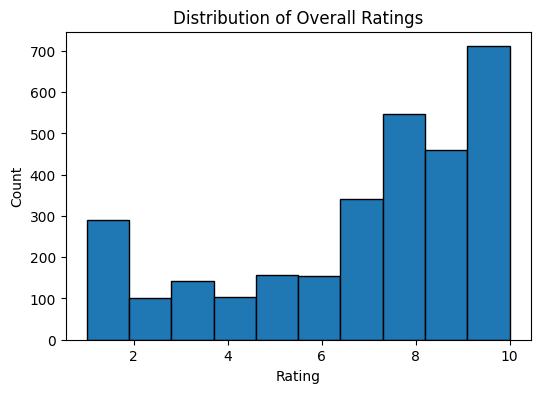

rating_class
pos    1718
neu     653
neg     635
Name: count, dtype: int64


In [7]:
import matplotlib.pyplot as plt

# overall rating
plt.figure(figsize=(6,4))
plt.hist(train_df['rating'], bins=10, edgecolor='k')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# if you’ll bucket into classes (e.g. 1–4 negative, 5–7 neutral, 8–10 positive),
# compute and print those class counts too:
train_df['rating_class'] = pd.cut(train_df['rating'], bins=[0,4,7,10], labels=['neg','neu','pos'])
print(train_df['rating_class'].value_counts())

## Step 2: Preprocessing

Before training, we'll clean the data, handle missing values, and prepare the review texts and labels for training.

In [8]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re

class TextPreprocessor:
    def __init__(self, max_words=20000, max_len=256):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizers = {}

    def clean_text(self, text):
        if pd.isnull(text):
            return ""
        text = text.strip().strip('"“”’')
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.lower()

    def clean_columns(self, df, columns):
        for col in columns:
            df[col] = df[col].apply(self.clean_text)
        return df

text_cols = ['commentsReview', 'benefitsReview', 'sideEffectsReview']
prep = TextPreprocessor()
train_df = prep.clean_columns(train_df, text_cols)
test_df = prep.clean_columns(test_df, text_cols)

bins = [0, 4, 7, 10]
labels = ['neg', 'neu', 'pos']

train_df['rating'] = pd.cut(train_df['rating'], bins=bins, labels=labels, include_lowest=True)
test_df['rating'] = pd.cut(test_df['rating'], bins=bins, labels=labels, include_lowest=True)

def normalize_target(text):
    if pd.isnull(text):
        return ""
    return text.strip().lower()


train_df['effectiveness'] = train_df['effectiveness'].apply(normalize_target)
test_df['effectiveness'] = test_df['effectiveness'].apply(normalize_target)
train_df['sideEffects'] = train_df['sideEffects'].apply(normalize_target)
test_df['sideEffects'] = test_df['sideEffects'].apply(normalize_target)

encoders = {
    'effectiveness': LabelEncoder(),
    'sideEffects': LabelEncoder(),
    'rating': LabelEncoder()
}

for target_col, encoder in encoders.items():
    train_df[f'label_{target_col}'] = encoder.fit_transform(train_df[target_col])
    test_df[f'label_{target_col}'] = encoder.transform(test_df[target_col])

for name, encoder in encoders.items():
    print(f"{name} classes:", list(encoder.classes_))

y_train = {
    'rating': train_df['label_rating'].values,
    'effectiveness': train_df['label_effectiveness'].values,
    'sideEffects': train_df['label_sideEffects'].values
}

y_test = {
    'rating': test_df['label_rating'].values,
    'effectiveness': test_df['label_effectiveness'].values,
    'sideEffects': test_df['label_sideEffects'].values
}

effectiveness classes: ['considerably effective', 'highly effective', 'ineffective', 'marginally effective', 'moderately effective']
sideEffects classes: ['extremely severe side effects', 'mild side effects', 'moderate side effects', 'no side effects', 'severe side effects']
rating classes: ['neg', 'neu', 'pos']


In [9]:
train_df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,rating_class,label_effectiveness,label_sideEffects,label_rating
0,enalapril,neg,highly effective,mild side effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",neg,1,1,0
1,ortho-tri-cyclen,neg,highly effective,severe side effects,birth prevention,although this type of birth control has more c...,"heavy cycle, cramps, hot flashes, fatigue, lon...","i hate this birth control, i would not suggest...",neg,1,4,0
2,ponstel,pos,highly effective,no side effects,menstrual cramps,i was used to having cramps so badly that they...,heavier bleeding and clotting than normal.,i took 2 pills at the onset of my menstrual cr...,pos,1,3,2
3,prilosec,neg,marginally effective,mild side effects,acid reflux,the acid reflux went away for a few months aft...,"constipation, dry mouth and some mild dizzines...",i was given prilosec prescription at a dose of...,neg,3,1,0
4,lyrica,neg,marginally effective,severe side effects,fibromyalgia,i think that the lyrica was starting to help w...,i felt extremely drugged and dopey. could not ...,see above,neg,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3102,vyvanse,pos,highly effective,mild side effects,adhd,"increased focus, attention, productivity. bett...","restless legs at night, insomnia, headache (so...","i took adderall once as a child, and it made m...",pos,1,1,2
3103,zoloft,neg,ineffective,extremely severe side effects,depression,emotions were somewhat blunted. less moodiness.,"weight gain, extreme tiredness during the day,...",i was on zoloft for about 2 years total. i am ...,neg,2,0,0
3104,climara,neg,marginally effective,moderate side effects,total hysterctomy,---,constant issues with the patch not staying on....,---,neg,3,2,0
3105,trileptal,pos,considerably effective,mild side effects,epilepsy,controlled complex partial seizures.,"dizziness, fatigue, nausea",started at 2 doses of 300 mg a day and worked ...,pos,0,1,2


## Step 3: Modeling with RNN, GRU, and LSTM

Here we implement and evaluate three different recurrent models to predict user sentiment:
- RNN
- GRU
- LSTM

In [10]:
!pip install keras

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import torch

class TokenizerManager:
    def __init__(self, tokenizer_type="keras", max_words=20000, max_len=128, model_name='bert-base-uncased'):
        self.tokenizer_type = tokenizer_type
        self.max_words = max_words
        self.max_len = max_len
        self.model_name = model_name
        self.tokenizers = {}

    def fit(self, train_df, text_columns):
        if self.tokenizer_type == "keras":
            for col in text_columns:
                tokenizer = Tokenizer(num_words=self.max_words, oov_token="<OOV>")
                tokenizer.fit_on_texts(train_df[col])
                self.tokenizers[col] = tokenizer
        elif self.tokenizer_type == "bert":
            tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            for col in text_columns:
                self.tokenizers[col] = tokenizer
        else:
            raise ValueError("Unsupported tokenizer type. Use 'keras' or 'bert'.")

    def transform(self, df, text_columns):
        inputs = {}

        for col in text_columns:
            tokenizer = self.tokenizers[col]

            if self.tokenizer_type == "keras":
                sequences = tokenizer.texts_to_sequences(df[col])
                padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
                inputs[col] = padded  # numpy array
            elif self.tokenizer_type == "bert":
                encoded = tokenizer(
                    list(df[col]),
                    padding='max_length',
                    truncation=True,
                    max_length=self.max_len,
                    return_tensors="pt"
                )
                inputs[col] = {
                    'input_ids': encoded['input_ids'],
                    'attention_mask': encoded['attention_mask']
                }
        return inputs

In [12]:
text_columns = ['commentsReview', 'benefitsReview', 'sideEffectsReview']

rnn_tok = TokenizerManager(tokenizer_type="keras", max_words=20000, max_len=300)
rnn_tok.fit(train_df, text_columns)

X_train_rnn = rnn_tok.transform(train_df, text_columns)
X_test_rnn = rnn_tok.transform(test_df, text_columns)

X_train_comments = X_train_rnn['commentsReview']
X_train_benefits = X_train_rnn['benefitsReview']
X_train_sideeffects = X_train_rnn['sideEffectsReview']

In [13]:
from torch.utils.data import Dataset
import torch

class ReviewDataset(Dataset):
    def __init__(self, input_array, labels):
        self.inputs = input_array  # should be a NumPy array or torch tensor
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.long)  # input token sequence
        y = self.labels[idx]  # label
        return x, y

In [14]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, n_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn       = nn.RNN(emb_dim, hid_dim, num_layers=n_layers,
                                batch_first=True, dropout=dropout)
        self.fc        = nn.Linear(hid_dim, out_dim)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.dropout(self.embedding(x))
        _, h = self.rnn(emb)                # h: (n_layers, batch, hid_dim)
        return self.fc(h[-1])               # (batch, out_dim)

class GRUClassifier(RNNClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.GRU(self.embedding.embedding_dim,
                          self.rnn.hidden_size,
                          num_layers=self.rnn.num_layers,
                          batch_first=True,
                          dropout=self.rnn.dropout)

class LSTMClassifier(RNNClassifier):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, n_layers=1, dropout=0.2):
        super().__init__(vocab_size, emb_dim, hid_dim, out_dim, n_layers, dropout)
        self.rnn = nn.LSTM(self.embedding.embedding_dim,
                           self.rnn.hidden_size,
                           num_layers=self.rnn.num_layers,
                           batch_first=True,
                           dropout=self.rnn.dropout)

    def forward(self, x):
        emb = self.dropout(self.embedding(x))
        _, (h, _) = self.rnn(emb)
        return self.fc(h[-1])

In [15]:
from tqdm.auto import tqdm
import torch

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for batch in loader:
            # Handle dict-style input (Transformers)
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                X, y = batch
                X, y = X.to(device), y.to(device)
                logits = model(X)
                labels = y

            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            all_preds.append(logits.argmax(dim=1).cpu())
            all_trues.append(labels.cpu())

    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(all_preds)
    trues = torch.cat(all_trues)

    metrics = {
        'loss': avg_loss,
        'accuracy':           accuracy_score(trues, preds),
        'balanced_accuracy':  balanced_accuracy_score(trues, preds),
        'precision':          precision_score(trues, preds, average='weighted', zero_division=0),
        'recall':             recall_score(trues, preds, average='weighted', zero_division=0),
        'f1':                 f1_score(trues, preds, average='weighted', zero_division=0),
        'confusion_matrix':   confusion_matrix(trues, preds)
    }
    return metrics

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names, model_name="Model", task_name="Task"):
    """
    Plots a confusion matrix with meaningful class names.
    
    Parameters:
    - cm: 2D confusion matrix array
    - class_names: list of class label names (e.g., ["neg", "neu", "pos"])
    - model_name: model architecture name
    - task_name: name of the prediction task (e.g., 'rating')
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - {task_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [17]:
def train_model(model, 
                train_loader, 
                val_loader, 
                optimizer, 
                criterion, 
                device, 
                n_epochs=5,
                model_name="MODEL",
                class_labels=None
               ):
    """
    Trains `model` and evaluates on val_loader each epoch.
    Returns a history dict you can later use to plot learning curves.
    """
    history = {
        'train_loss': [], 
        'val_loss':   [], 
        'accuracy':   [], 
        'balanced_accuracy': [], 
        'precision':  [], 
        'recall':     [], 
        'f1':         []
    }

    for epoch in range(1, n_epochs+1):
        model.train()
        running_loss = 0

        for batch in tqdm(train_loader, desc=f"{model_name} Train Ep{epoch}", leave=False):
            # Handle dict-style input (for transformers)
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)
            else:
                # RNN-style input
                X, y = batch
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)
                labels = y  # for metrics

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)

        # — eval epoch —
        metrics = evaluate_model(model, val_loader, criterion, device)
        history['val_loss'].append(metrics['loss'])
        history['accuracy'].append(metrics['accuracy'])
        history['balanced_accuracy'].append(metrics['balanced_accuracy'])
        history['precision'].append(metrics['precision'])
        history['recall'].append(metrics['recall'])
        history['f1'].append(metrics['f1'])

        # — print a summary line —
        print(
            f"{model_name} Ep{epoch:>2} │ "
            f"train_loss={avg_train_loss:.3f} │ "
            f"val_loss={metrics['loss']:.3f} │ "
            f"acc={metrics['accuracy']:.3f} │ "
            f"bacc={metrics['balanced_accuracy']:.3f} │ "
            f"f1={metrics['f1']:.3f}"
        )

    print(f"\nFinal {model_name} Confusion Matrix:\n", metrics['confusion_matrix'])
    if class_labels is None:
        class_labels = [str(i) for i in range(metrics['confusion_matrix'].shape[0])]
    plot_confusion_matrix(metrics['confusion_matrix'], class_names=class_labels, model_name=model_name, task_name=model_name.split('-')[-1])
    return history

In [18]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()


🔍 Optimizing RNN on rating...
→ Best RNN-rating params: [4, 146, 0.38984550013638475, 0.001562069367563987]

▶ Retraining RNN on rating …


RNN-rating-Best Train Ep1:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 1 │ train_loss=1.108 │ val_loss=1.103 │ acc=0.230 │ bacc=0.330 │ f1=0.087


RNN-rating-Best Train Ep2:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 2 │ train_loss=1.109 │ val_loss=1.106 │ acc=0.338 │ bacc=0.339 │ f1=0.332


RNN-rating-Best Train Ep3:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 3 │ train_loss=1.125 │ val_loss=1.121 │ acc=0.392 │ bacc=0.342 │ f1=0.356


RNN-rating-Best Train Ep4:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 4 │ train_loss=1.107 │ val_loss=1.106 │ acc=0.387 │ bacc=0.339 │ f1=0.352


RNN-rating-Best Train Ep5:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 5 │ train_loss=1.106 │ val_loss=1.099 │ acc=0.387 │ bacc=0.339 │ f1=0.352


RNN-rating-Best Train Ep6:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-rating-Best Ep 6 │ train_loss=1.101 │ val_loss=1.099 │ acc=0.380 │ bacc=0.328 │ f1=0.344

Final RNN-rating-Best Confusion Matrix:
 [[  0 108 126]
 [  0 118 128]
 [  0 262 265]]


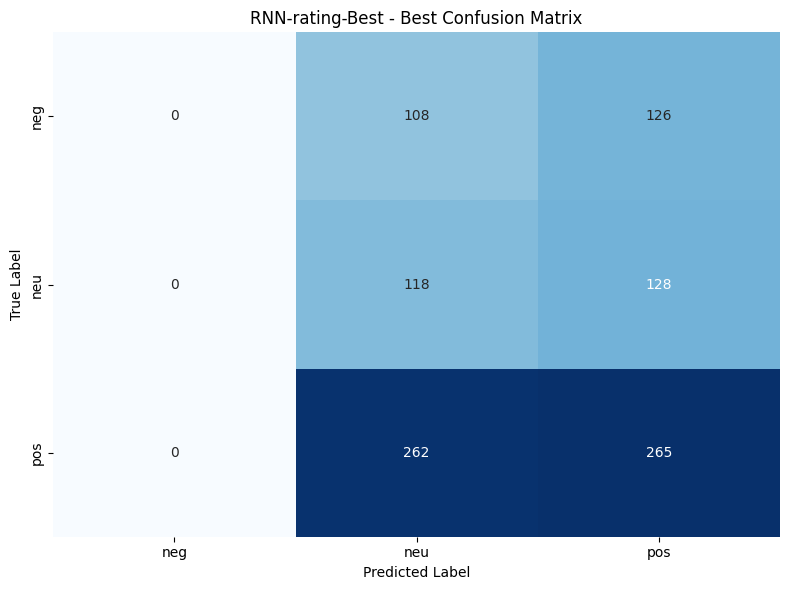

✅ Saved: rnn_rating_best_state_dict.pth

🔍 Optimizing RNN on effectiveness...
→ Best RNN-effectiveness params: [4, 512, 0.5, 0.00036682973239303293]

▶ Retraining RNN on effectiveness …


RNN-effectiveness-Best Train Ep1:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 1 │ train_loss=1.621 │ val_loss=1.612 │ acc=0.077 │ bacc=0.200 │ f1=0.011


RNN-effectiveness-Best Train Ep2:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 2 │ train_loss=1.664 │ val_loss=1.781 │ acc=0.115 │ bacc=0.147 │ f1=0.125


RNN-effectiveness-Best Train Ep3:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 3 │ train_loss=1.689 │ val_loss=1.711 │ acc=0.139 │ bacc=0.182 │ f1=0.114


RNN-effectiveness-Best Train Ep4:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 4 │ train_loss=1.668 │ val_loss=1.638 │ acc=0.214 │ bacc=0.243 │ f1=0.214


RNN-effectiveness-Best Train Ep5:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 5 │ train_loss=1.677 │ val_loss=1.632 │ acc=0.229 │ bacc=0.182 │ f1=0.204


RNN-effectiveness-Best Train Ep6:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-effectiveness-Best Ep 6 │ train_loss=1.647 │ val_loss=1.644 │ acc=0.128 │ bacc=0.203 │ f1=0.109

Final RNN-effectiveness-Best Confusion Matrix:
 [[ 43   0  75 124  64]
 [ 47   0  95 162  89]
 [ 10   0  14  46   8]
 [  8   0  14  32  19]
 [ 24   0  40  53  40]]


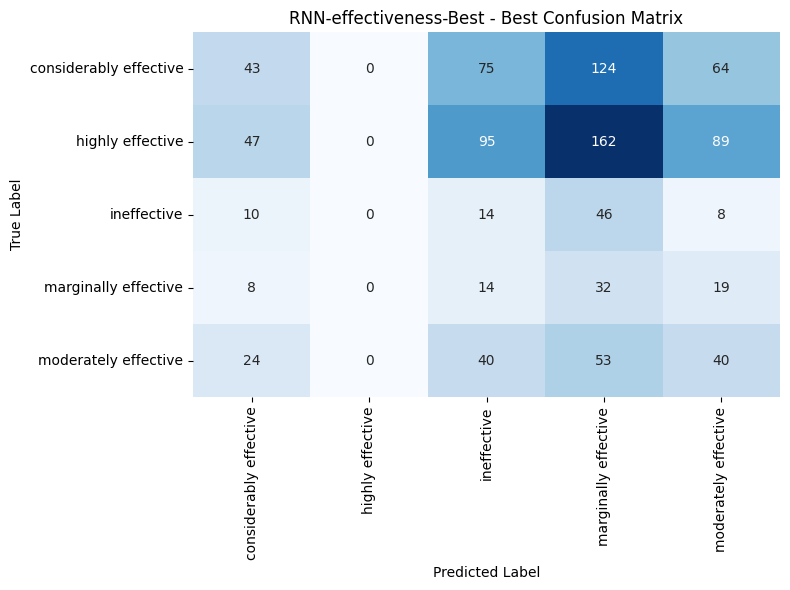

✅ Saved: rnn_effectiveness_best_state_dict.pth

🔍 Optimizing RNN on sideEffects...
→ Best RNN-sideEffects params: [2, 486, 0.2816441089227697, 0.0005899741796710488]

▶ Retraining RNN on sideEffects …


RNN-sideEffects-Best Train Ep1:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 1 │ train_loss=1.616 │ val_loss=1.614 │ acc=0.243 │ bacc=0.202 │ f1=0.097


RNN-sideEffects-Best Train Ep2:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 2 │ train_loss=1.608 │ val_loss=1.616 │ acc=0.243 │ bacc=0.202 │ f1=0.097


RNN-sideEffects-Best Train Ep3:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 3 │ train_loss=1.628 │ val_loss=1.826 │ acc=0.208 │ bacc=0.221 │ f1=0.178


RNN-sideEffects-Best Train Ep4:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 4 │ train_loss=1.724 │ val_loss=1.650 │ acc=0.277 │ bacc=0.219 │ f1=0.263


RNN-sideEffects-Best Train Ep5:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 5 │ train_loss=1.629 │ val_loss=1.617 │ acc=0.299 │ bacc=0.250 │ f1=0.191


RNN-sideEffects-Best Train Ep6:   0%|          | 0/47 [00:00<?, ?it/s]

RNN-sideEffects-Best Ep 6 │ train_loss=1.620 │ val_loss=1.628 │ acc=0.226 │ bacc=0.238 │ f1=0.137

Final RNN-sideEffects-Best Confusion Matrix:
 [[ 13   0   0  47  17]
 [ 77   0   0 169  84]
 [ 57   0   0 114  64]
 [ 17   0   0 181  46]
 [ 23   0   0  64  34]]


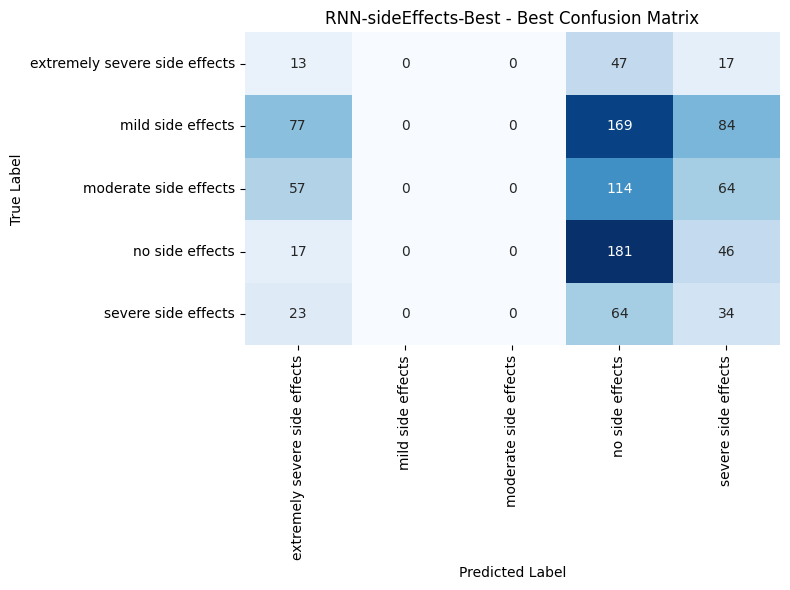

✅ Saved: rnn_sideEffects_best_state_dict.pth

🔍 Optimizing GRU on rating...


ValueError: Input y contains NaN.

In [19]:
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

search_space = [
    Integer(2, 5, name='n_layers'),
    Integer(64, 512, name='hid_dim'),
    Real(0.0, 0.5, name='dropout'),
    Real(1e-4, 1e-2, prior='log-uniform', name='lr'),
]

vocab_size = rnn_tok.tokenizers['commentsReview'].num_words or \
             (len(rnn_tok.tokenizers['commentsReview'].word_index) + 1)

label_names = {
    'rating': encoders['rating'].classes_.tolist(),
    'effectiveness': encoders['effectiveness'].classes_.tolist(),
    'sideEffects': encoders['sideEffects'].classes_.tolist()
}

# Store results
opt_results     = {}
best_histories  = {}
best_models     = {}

# Tasks
TASKS = {
    'rating':        ('commentsReview', y_train['rating'], y_test['rating']),
    'effectiveness': ('benefitsReview', y_train['effectiveness'], y_test['effectiveness']),
    'sideEffects':  ('sideEffectsReview', y_train['sideEffects'], y_test['sideEffects'])
}

# Model loop
for ModelCls, model_name in [
    (RNNClassifier,  "RNN"),
    (GRUClassifier,  "GRU"),
    (LSTMClassifier, "LSTM")
]:
    for task_name, (col, y_train_task, y_test_task) in TASKS.items():
        print(f"\n🔍 Optimizing {model_name} on {task_name}...")

        # Set inputs and labels
        X_train_task = X_train_rnn[col]
        X_test_task  = X_test_rnn[col]
        out_dim = len(set(y_train_task)) 

        # Dataset & DataLoader
        train_ds = ReviewDataset(X_train_task, y_train_task)
        test_ds  = ReviewDataset(X_test_task,  y_test_task)

        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

        # Define objective function
        @use_named_args(search_space)
        def objective(n_layers, hid_dim, dropout, lr):
            model = ModelCls(
                vocab_size=int(vocab_size),
                emb_dim=128,
                hid_dim=int(hid_dim),
                out_dim=int(out_dim),
                n_layers=int(n_layers),
                dropout=float(dropout)
            ).to(device)
        
            optimizer = torch.optim.Adam(model.parameters(), lr=float(lr))
            criterion = nn.CrossEntropyLoss()
        
            for _ in range(1):
                train_epoch(model, train_loader, optimizer, criterion)
        
            metrics = evaluate_model(model, test_loader, criterion, device)
            return metrics['loss']

        # Run Bayesian Optimization
        result = gp_minimize(
            func        = objective,
            dimensions  = search_space,
            acq_func    = 'EI',
            n_calls     = 20,
            random_state=42
        )

        opt_results[(model_name, task_name)] = result
        best_params = result.x
        print(f"→ Best {model_name}-{task_name} params:", best_params)

        # Re-train with best params
        n_layers, hid_dim, dropout, lr = best_params

        final_model = ModelCls(
            vocab_size=int(vocab_size),
            emb_dim=128,
            hid_dim=int(hid_dim),
            out_dim=int(out_dim),
            n_layers=int(n_layers),
            dropout=float(dropout)
        ).to(device)
        
        optimizer = torch.optim.Adam(final_model.parameters(), lr=float(lr))
        
        classes = np.unique(y_train_task)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train_task
        )
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

        print(f"\n▶ Retraining {model_name} on {task_name} …")
        hist = train_model(
            model       = final_model,
            train_loader= train_loader,
            val_loader  = test_loader,
            optimizer   = optimizer,
            criterion   = criterion,
            device      = device,
            n_epochs    = 6,
            model_name  = f"{model_name}-{task_name}-Best",
            class_labels= label_names[task_name]
        )

        # Save everything
        best_histories[(model_name, task_name)] = hist
        best_models[(model_name, task_name)] = final_model

        fname_prefix = f"{model_name.lower()}_{task_name}"
        torch.save(final_model.state_dict(), f"{fname_prefix}_best_state_dict.pth")
        torch.save(final_model, f"{fname_prefix}_best_full_model.pth")
        print(f"✅ Saved: {fname_prefix}_best_state_dict.pth")

## Step 4: Modeling with GPT2 and BERT¶

Here we implement and evaluate two different transformer models to predict user sentiment

In [ ]:
class TransformerReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [ ]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', output_dim=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.last_hidden_state[:, 0, :])  # CLS token

In [ ]:
class GPT2SentimentClassifier(nn.Module):
    def __init__(self, model_name='gpt2', output_dim=3):
        super().__init__()
        self.gpt2 = AutoModel.from_pretrained(model_name)
        self.fc = nn.Linear(self.gpt2.config.n_embd, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.last_hidden_state[:, -1, :])  # last token

In [ ]:
from transformers import AutoTokenizer, AutoModel

for model_name, ModelCls in [
    ("BERT", BERTSentimentClassifier),
    ("GPT2", GPT2SentimentClassifier)
]:
    for task_name, (col, y_train_task, y_test_task) in TASKS.items():
        print(f"\n🚀 Training {model_name} on {task_name}...")

        # Choose tokenizer
        pretrained_model = 'bert-base-uncased' if model_name == "BERT" else 'gpt2'
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        if model_name == "GPT2":
            tokenizer.pad_token = tokenizer.eos_token  # fix GPT2 padding

        # Encode text
        train_enc = tokenizer(
            list(train_df[col]), truncation=True, padding='max_length',
            max_length=128, return_tensors='pt'
        )
        test_enc = tokenizer(
            list(test_df[col]), truncation=True, padding='max_length',
            max_length=128, return_tensors='pt'
        )

        # Build datasets and loaders
        train_ds = TransformerReviewDataset(train_enc, y_train_task)
        test_ds  = TransformerReviewDataset(test_enc, y_test_task)

        train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
        test_loader  = DataLoader(test_ds, batch_size=16)

        # Init model
        out_dim = len(set(y_train_task))
        model = ModelCls(model_name=pretrained_model, output_dim=out_dim).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        
        classes = np.unique(y_train_task)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train_task
        )
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

        # Train
        hist = train_model(
            model       = model,
            train_loader= train_loader,
            val_loader  = test_loader,
            optimizer   = optimizer,
            criterion   = criterion,
            device      = device,
            n_epochs    = 6,
            model_name  = f"{model_name}-{task_name}",
            class_labels= label_names[task_name]
        )

        # Save
        torch.save(model.state_dict(), f"{model_name.lower()}_{task_name}_state_dict.pth")
        best_models[(model_name, task_name)] = model
        best_histories[(model_name, task_name)] = hist
        print(f"✅ Saved {model_name}-{task_name} model\n")

## Step 5: Evaluation & Comparison

We will compare the models using accuracy, F1-score, precision, and recall to determine the best-performing architecture for each sentiment category.

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(histories, metric='f1', title='Model Comparison - F1 Score'):
    """
    Plots learning curves for multiple models and tasks.

    Parameters:
    - histories: dict with keys like (model_name, task_name) and values as history dicts
    - metric: which metric to plot ('f1', 'accuracy', 'val_loss', etc.)
    - title: overall plot title
    """
    plt.figure(figsize=(14, 8))
    for (model_name, task_name), hist in histories.items():
        if metric in hist:
            plt.plot(hist[metric], label=f"{model_name} - {task_name}")
    
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_learning_curves(best_histories, metric='f1', title='Model Comparison - F1 Score')
plot_learning_curves(best_histories, metric='accuracy', title='Model Comparison - Accuracy')